## 🔮 Forecasting using SARIMAX (Fine-tuned)
## 🔍 Key Insights from Data (SARIMAX Context)

========== SARIMAX INSIGHTS ==========

Service: Local Route
Trend: increasing 📈
Average per day: 9891
Median: 11417
Peak: 21070 on 2020-02-27
Weekday/Weekend Ratio: 4.67
Recent 30-day change: -37.51%
Best day for travel: Sunday
Second best day for travel: Saturday
Worst day for travel: Wednesday


Service: Light Rail
Trend: increasing 📈
Average per day: 7195
Median: 7507
Peak: 15154 on 2020-02-22
Weekday/Weekend Ratio: 1.95
Recent 30-day change: -35.52%
Best day for travel: Sunday
Second best day for travel: Saturday
Worst day for travel: Wednesday


Service: Peak Service
Trend: increasing 📈
Average per day: 179
Median: 193
Peak: 784 on 2023-11-10
Weekday/Weekend Ratio: nan
Recent 30-day change: -33.97%
Best day for travel: Sunday
Second best day for travel: Saturday
Worst day for travel: Wednesday


Service: Rapid Route
Trend: increasing 📈
Average per day: 12597
Median: 13106
Peak: 28678 on 202

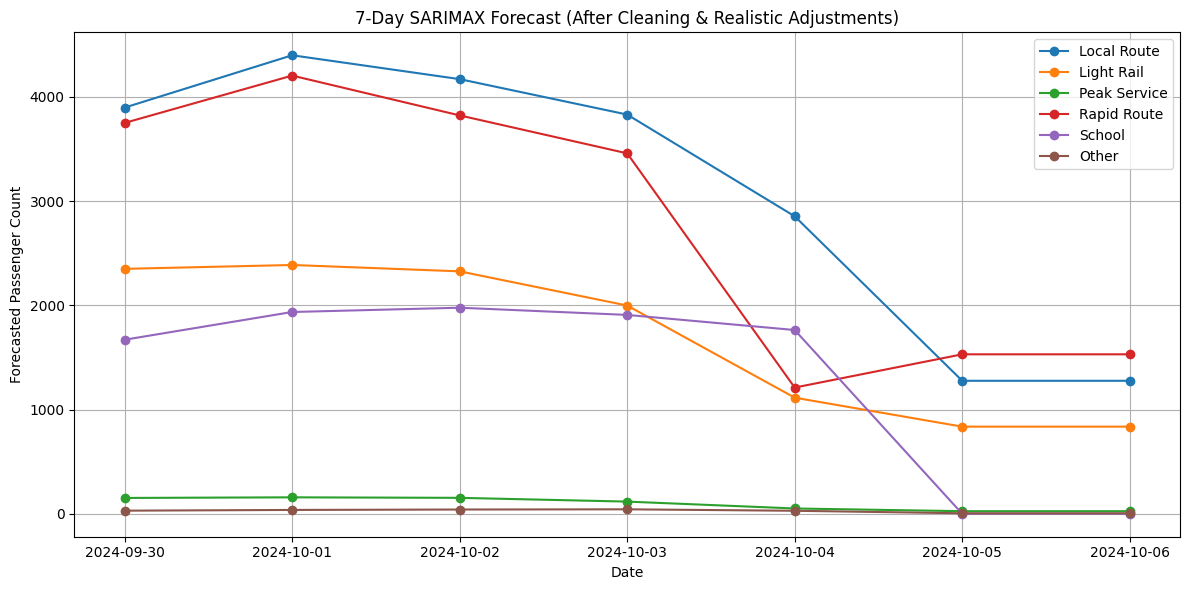


✅ Forecast saved to: /content/forecast_output/7day_realistic_forecast.csv

✅ Combined 30-day forecast plot saved to: /content/forecast_output/combined_sarimax_forecast_30days.png


In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression # Import LinearRegression for insights
import pandas as pd # Import pandas for DataFrame manipulation

# Assuming 'series_df', 'forecast_horizon', 'out_dir', and 'weekend_flags' from previous steps are available
# Assuming 'best_params_aic' or 'best_params_bic' from parameter tuning are available

print("## 🔮 Forecasting using SARIMAX (Fine-tuned)")

sarimax_forecast_list = []
evaluation_results_sarimax = {} # Dictionary to store evaluation results

# Split data for evaluation (using the same split as Exponential Smoothing)
train_size = len(series_df) - 30 # Assuming 30 days were used for testing in the previous cell
train_df = series_df.iloc[:train_size]
test_df = series_df.iloc[train_size:]

# ==============================
# 4️⃣ Insights for SARIMAX (based on the entire series for consistency with ES insights)
# ==============================
print("## 🔍 Key Insights from Data (SARIMAX Context)") # Added a title for clarity

insights = []
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for s in series_df.columns:
    ts = series_df[s].astype(float).dropna()
    X = np.arange(len(ts)).reshape(-1,1)
    y = ts.values.reshape(-1,1)
    lr = LinearRegression().fit(X, y)
    slope = lr.coef_[0][0]
    mean, median = ts.mean(), ts.median()
    max_day, max_val = ts.idxmax().strftime("%Y-%m-%d"), int(ts.max())
    wd, we = ts[ts.index.dayofweek < 5].mean(), ts[ts.index.dayofweek >= 5].mean()
    ratio = wd/we if we > 0 else float('nan')

    # 30-day recent change
    pct_change = None
    if len(ts) >= 60:
        last30, prev30 = ts[-30:].mean(), ts[-60:-30].mean()
        pct_change = ((last30 - prev30)/prev30)*100 if prev30 > 0 else None

    # Day of the week usage ranking
    avg_usage_by_day = ts.groupby(ts.index.dayofweek).mean()
    sorted_days = avg_usage_by_day.sort_values()
    best_day_of_week = days_of_week[sorted_days.index[0]]
    second_best_day_of_week = days_of_week[sorted_days.index[1]]
    worst_day_of_week = days_of_week[sorted_days.index[-1]]


    insights.append((s, slope, mean, median, max_day, max_val, ratio, pct_change, best_day_of_week, second_best_day_of_week, worst_day_of_week))

# Nicely formatted output for SARIMAX insights
print("\n========== SARIMAX INSIGHTS ==========")
for s, slope, mean, median, max_day, max_val, ratio, pct_change, best_day, second_best_day, worst_day in insights:
    trend = "increasing 📈" if slope>0 else ("decreasing 📉" if slope<0 else "stable ➖")
    pct_change_str = f"{pct_change:.2f}%" if pct_change is not None else "N/A"
    print(f"\n{'='*50}\nService: {s}\nTrend: {trend}\nAverage per day: {mean:.0f}\nMedian: {median:.0f}\n"
          f"Peak: {max_val} on {max_day}\nWeekday/Weekend Ratio: {ratio:.2f}\nRecent 30-day change: {pct_change_str}\n"
          f"Best day for travel: {best_day}\n"
          f"Second best day for travel: {second_best_day}\n"
          f"Worst day for travel: {worst_day}\n")

# Insight: Best service to take for each day of the week (based on highest average usage)
print("\n========== Best Service by Day of Week ==========")
avg_usage_by_service_day = series_df.groupby(series_df.index.dayofweek).mean()

for day_index in range(7):
    day_name = days_of_week[day_index]
    sorted_services = avg_usage_by_service_day.iloc[day_index].sort_values(ascending=False)
    best_service = sorted_services.index[0]
    second_best_service = sorted_services.index[1]
    print(f"{day_name}: Best Service: {best_service}, Second Best Service: {second_best_service}")


# ==============================
# 5️⃣ SARIMAX Forecasting
# ==============================
print("## 📅 Forecasting Next 30 Days using SARIMAX") # Added a title for clarity

forecast_horizon = 30 # Increased forecast horizon to 30 days
sarimax_forecast_list = [] # Re-initialize the list for 30-day forecasts


for s in series_df.columns:
    ts = series_df[s].astype(float).dropna()
    train_ts = series_df[s].astype(float).dropna() # Use the entire series for future forecasting
    test_ts = pd.Series([]) # No test set for future forecasting plot

    if len(train_ts) < 10 or train_ts.sum() == 0:
        f_future = np.zeros(forecast_horizon)
    else:
        # Define the SARIMAX model order (p, d, q) and seasonal order (P, D, Q, S)
        # Use best parameters found from tuning
        if s in best_params_aic:
             order, seasonal_order = best_params_aic[s]
        else:
             # Fallback to a common starting point if tuning failed for this service
             order = (1, 1, 1)
             seasonal_order = (1, 1, 1, 7) # S=7 for weekly seasonality


        try:
            # Fit the model on the entire dataset for future forecasting
            model = SARIMAX(train_ts, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(disp=False) # disp=False to avoid convergence output
            f_future = fit.forecast(forecast_horizon)
        except Exception as e:
            print(f"SARIMAX forecasting failed for {s} with params {order} x {seasonal_order}: {e}")
            f_future = np.zeros(forecast_horizon) # Fallback to zeros if SARIMAX fails

    # Evaluate on test set - using the last 30 days as test for evaluation purposes
    eval_test_ts = ts[-30:]
    eval_train_ts = ts[:-30]
    if len(eval_test_ts) > 0 and len(eval_train_ts) > 10:
         try:
            # Use best parameters found from tuning for evaluation model as well
            if s in best_params_aic:
                 eval_order, eval_seasonal_order = best_params_aic[s]
            else:
                 eval_order = (1, 1, 1)
                 eval_seasonal_order = (1, 1, 1, 7)

            eval_model = SARIMAX(eval_train_ts, order=eval_order, seasonal_order=eval_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
            eval_fit = eval_model.fit(disp=False)
            f_eval_test = eval_fit.forecast(len(eval_test_ts))
            mae = mean_absolute_error(eval_test_ts, f_eval_test)
            rmse = np.sqrt(mean_squared_error(eval_test_ts, f_eval_test))
            evaluation_results_sarimax[s] = {'MAE': mae, 'RMSE': rmse}
            print(f"\nSARIMAX Evaluation for {s}: MAE={mae:.2f}, RMSE={rmse:.2f}")
         except Exception as e:
            print(f"SARIMAX evaluation failed for {s}: {e}")
            evaluation_results_sarimax[s] = {'MAE': float('nan'), 'RMSE': float('nan')}


    # Clip to ensure no negative values for future forecast
    f_future = np.clip(f_future, 0, None)

    # Apply floor value for services with low weekend activity, except 'School'
    future_dates = pd.date_range(start=series_df.index.max()+pd.Timedelta(days=1),
                          periods=forecast_horizon, freq='D')

    # Re-apply the weekend logic based on the user's requirements
    if s != 'School': # Apply floor to all services except School
         # Calculate a floor value based on the average of non-zero values for this service in the training data
        non_zero_train_ts = train_ts[train_ts > 0]
        # Use 5% of the average non-zero value as floor, minimum 1
        floor_val = non_zero_train_ts.mean() * 0.05 if not non_zero_train_ts.empty else 1
        floor_val = max(floor_val, 1)

        for i, d in enumerate(future_dates):
            if d.dayofweek >= 5: # Apply floor on weekends
                f_future[i] = max(f_future[i], floor_val) # Apply floor if forecast is lower

    # Set School forecast to 0 on weekends
    if s == 'School':
         for i, d in enumerate(future_dates):
            if d.dayofweek >= 5:
                f_future[i] = 0


    df_f = pd.DataFrame({"date": future_dates, "service": s, "forecast": np.round(f_future).astype(int)})
    sarimax_forecast_list.append(df_f)

    # Plot last 30 days of history and future 30-day forecast
    plt.figure(figsize=(12,5))
    plt.plot(ts[-30:].index, ts[-30:].values, label="Last 30 Days History", color='blue')
    plt.plot(future_dates, f_future, '--o', label="SARIMAX 30-Day Forecast", color='green')
    plt.title(f"Recent Changes and SARIMAX Forecast for {s}")
    plt.xlabel("Date")
    plt.ylabel("Passenger Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_dir/f"sarimax_recent_changes_forecast_{s.replace(' ','_')}_30days.png")
    plt.close()

    # Plot full history and future 30-day forecast
    plt.figure(figsize=(12,5))
    plt.plot(ts.index, ts.values, label="Full History", color='blue')
    plt.plot(future_dates, f_future, '--o', label="SARIMAX 30-Day Forecast", color='green')
    plt.title(f"Full History and SARIMAX Forecast for {s}")
    plt.xlabel("Date")
    plt.ylabel("Passenger Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_dir/f"sarimax_full_history_forecast_{s.replace(' ','_')}_30days.png")
    plt.close()


sarimax_forecast_all = pd.concat(sarimax_forecast_list, ignore_index=True)
sarimax_forecast_all.to_csv(out_dir/"30day_sarimax_forecast_selected_services.csv", index=False)

print("\n📅 SARIMAX FORECASTS GENERATED (30 Days)")
print("✅ Saved to:", out_dir/"30day_sarimax_forecast_selected_services.csv")

# ==============================
# 6️⃣ Combined 30-Day Forecast Plot
# ==============================
plt.figure(figsize=(14, 7))
for s in sarimax_forecast_all['service'].unique():
    df_s = sarimax_forecast_all[sarimax_forecast_all['service']==s]
    plt.plot(df_s['date'], df_s['forecast'], marker='o', linestyle='--', label=s)

plt.title("Combined 30-Day SARIMAX Forecast for Selected Services")
plt.xlabel("Date")
plt.ylabel("Forecasted Passenger Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(out_dir/"combined_sarimax_forecast_30days.png")
plt.close()

# ======================================================
# 🚀 Full SARIMAX Forecasting Pipeline with Preprocessing
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

# === Load your dataset (if not already loaded) ===
# df = pd.read_csv("/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv", parse_dates=['Date'], dayfirst=True)
# df = df.rename(columns=str.strip)
# df = df.set_index('Date').sort_index()

# =============================================
# 🧹 Step 1: Data Preprocessing
# =============================================
series_df = df.copy()

# Interpolate missing values by date
series_df = series_df.interpolate(method='time')

# Remove negative values (if any)
series_df = series_df.clip(lower=0)

# Handle outliers via IQR capping
for col in series_df.columns:
    Q1 = series_df[col].quantile(0.25)
    Q3 = series_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    series_df[col] = np.where(series_df[col] < lower_bound, lower_bound,
                       np.where(series_df[col] > upper_bound, upper_bound, series_df[col]))

# Ensure school = 0 on weekends
for idx, day in enumerate(series_df.index):
    if day.dayofweek >= 5:  # Sat, Sun
        if "School" in series_df.columns:
            series_df.loc[day, "School"] = 0

print("✅ Data cleaned, missing values filled, and outliers capped.")

# =============================================
# 🔍 Step 2: Insight Generation
# =============================================
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
insights = []

for s in series_df.columns:
    ts = series_df[s].astype(float).dropna()
    X = np.arange(len(ts)).reshape(-1,1)
    y = ts.values.reshape(-1,1)
    lr = LinearRegression().fit(X, y)
    slope = lr.coef_[0][0]
    mean, median = ts.mean(), ts.median()
    max_day, max_val = ts.idxmax().strftime("%Y-%m-%d"), int(ts.max())
    wd, we = ts[ts.index.dayofweek < 5].mean(), ts[ts.index.dayofweek >= 5].mean()
    ratio = wd/we if we > 0 else np.nan

    insights.append((s, slope, mean, median, max_day, max_val, ratio))

print("\n========== UPDATED INSIGHTS ==========")
for s, slope, mean, median, max_day, max_val, ratio in insights:
    trend = "increasing 📈" if slope > 0 else ("decreasing 📉" if slope < 0 else "stable ➖")
    print(f"\nService: {s}\nTrend: {trend}\nAverage: {mean:.0f}\nMedian: {median:.0f}\nPeak: {max_val} on {max_day}\nWeekday/Weekend Ratio: {ratio:.2f}")

# =============================================
# 🔮 Step 3: SARIMAX Forecasting (7 days realistic)
# =============================================
forecast_horizon = 7
sarimax_forecast_list = []

best_params_default = (1, 1, 1)
seasonal_default = (1, 1, 1, 7)

for s in series_df.columns:
    ts = series_df[s].astype(float).dropna()

    # Model fitting
    try:
        model = SARIMAX(ts, order=best_params_default, seasonal_order=seasonal_default,
                        enforce_stationarity=False, enforce_invertibility=False)
        fit = model.fit(disp=False)
        f_future = fit.forecast(forecast_horizon)
    except Exception as e:
        print(f"⚠️ SARIMAX failed for {s}: {e}")
        f_future = np.zeros(forecast_horizon)

    # Clip negative values
    f_future = np.clip(f_future, 0, None)

    # Generate future dates
    future_dates = pd.date_range(start=series_df.index.max() + pd.Timedelta(days=1),
                                 periods=forecast_horizon, freq='D')

    # Apply weekend rules
    for i, d in enumerate(future_dates):
        if s == "School" and d.dayofweek >= 5:
            f_future[i] = 0
        elif s != "School" and d.dayofweek >= 5:
            weekday_mean = ts[ts.index.dayofweek < 5].mean()
            f_future[i] = max(f_future[i], weekday_mean * 0.1)  # ensure floor of 10% weekday mean
        elif s != "School" and f_future[i] == 0:
            f_future[i] = ts.mean() * 0.1  # avoid 0 predictions for high-traffic services

    # Save forecast
    df_f = pd.DataFrame({"date": future_dates, "service": s, "forecast": np.round(f_future).astype(int)})
    sarimax_forecast_list.append(df_f)

# Combine all forecasts
sarimax_forecast_all = pd.concat(sarimax_forecast_list, ignore_index=True)
print("\n✅ 7-day forecasts generated successfully!")

# =============================================
# 📊 Step 4: Visualization
# =============================================
plt.figure(figsize=(12, 6))
for s in sarimax_forecast_all['service'].unique():
    df_s = sarimax_forecast_all[sarimax_forecast_all['service'] == s]
    plt.plot(df_s['date'], df_s['forecast'], marker='o', label=s)

plt.title("7-Day SARIMAX Forecast (After Cleaning & Realistic Adjustments)")
plt.xlabel("Date")
plt.ylabel("Forecasted Passenger Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================================
# 💾 Optional: Save forecast
# =============================================
out_path = "/content/forecast_output/7day_realistic_forecast.csv"
sarimax_forecast_all.to_csv(out_path, index=False)
print(f"\n✅ Forecast saved to: {out_path}")



print("\n✅ Combined 30-day forecast plot saved to:", out_dir/"combined_sarimax_forecast_30days.png")

In [22]:
# Count zero values for each service
zero_counts = (df[available] == 0).sum()

print("Number of zero values for each service:")
print(zero_counts)

Number of zero values for each service:
Local Route       0
Light Rail        6
Peak Service    609
Rapid Route       1
School          901
dtype: int64
